# Imports

In [1]:
import torch
from table_bert import TableBertModel, Table, Column
import pandas as pd
import random
import numpy as np
import nltk

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from sklearn.neighbors import NearestNeighbors

# Models and Data

In [2]:
kvalue = 3

model = TableBertModel.from_pretrained(
    f'../TaBERT-master/models/tabert_base_k{kvalue}/model.bin',
)

In [3]:
results = []

matches_df = pd.read_csv("../data/embedding-evaluation/amazon-google/data/matches.csv", encoding='latin-1').fillna("")
matches_df = matches_df.astype(str)
matches_df = matches_df.sample(frac=1).reset_index(drop=True)
matches_df.columns = [0, 1]

amazon_df = pd.read_csv("../data/embedding-evaluation/amazon-google/data/set1-orig.csv", encoding='latin-1').fillna("")
amazon_df = amazon_df.astype(str)
amazon_df.drop(columns=['description', 'manufacturer'], inplace=True)
amazon_df.columns = ['id', 'name', 'price']

google_df = pd.read_csv("../data/embedding-evaluation/amazon-google/data/set2-orig.csv", encoding='latin-1').fillna("")
google_df = google_df.astype(str)
google_df.drop(columns=['description', 'manufacturer'], inplace=True)
google_df.columns = ['id', 'name', 'price']

# Methods

In [4]:
from nltk import ngrams

def lookup(id, databases, database_index):
    database = databases[database_index]
    return list(database[database['id'] == id].iloc[0][['name', 'price']])

def get_index(id, databases, database_index):
    return databases[database_index][databases[database_index]['id'] == id].index.values[0]

def get_ngram_overlap_ratio(context, table, ngram_num):
    tokens = list(nltk.ngrams(context, ngram_num))
    ret = pd.Series([0 for row in table])
    trigrams_series = pd.Series([list(nltk.ngrams(row, ngram_num)) for row in table])

    for token in tokens:
        ret[trigrams_series[trigrams_series.apply(lambda x: token in x)].index.values] += 1
        
    return ret

# Content Snapshot Testing

In [30]:
content_snapshot_method = 'top bigram+trigram token-level overlap ratio'
content_snapshot_ngrams = [1, 3]

In [31]:
databases = [amazon_df, google_df]
amazon_table_data = [model.tokenizer.tokenize(", ".join([row['name'], row['price']])) for index, row in amazon_df.iterrows()]
google_table_data = [model.tokenizer.tokenize(", ".join([row['name'], row['price']])) for index, row in google_df.iterrows()]

random.shuffle(amazon_table_data)
random.shuffle(google_table_data)

tables = [pd.Series(amazon_table_data), pd.Series(google_table_data)]

In [33]:
num_matches = 1
matches_sample = matches_df.sample(num_matches)
positions = []

for index, query_row in matches_df.iloc[[970]].iterrows():
    database_index, database_name = random.choice([(0, 'Amazon'), (1, 'Google')])

    query_list = lookup(query_row[database_index], databases, database_index)
    query_matching_list = lookup(query_row[1-database_index], databases, 1-database_index)
    query = model.tokenizer.tokenize(", ".join(query_list))
    query_matching = model.tokenizer.tokenize(", ".join(query_matching_list))
    query_matching_index = tables[1-database_index].index[tables[1-database_index].tolist().index(query_matching)]
    
    content_snapshot_order = get_ngram_overlap_ratio(query, tables[1-database_index], content_snapshot_ngrams[0])
    for ngram_num in content_snapshot_ngrams[1:]:
        content_snapshot_order += get_ngram_overlap_ratio(query, tables[1-database_index], ngram_num)
    content_snapshot_order = list(content_snapshot_order.sort_values(ascending=False).index.values)
    
    positions.append(content_snapshot_order.index(query_matching_index)+1)
        
results = [content_snapshot_method, positions]

print(positions)

[1]


results_df = pd.DataFrame([results], columns=['Content Snaphot Method', 'Positions'])
try:
    updated_results = pd.concat((pd.read_csv(r'../results/TaBERT/results.csv'), results_df))
except:
    updated_results = results_df.copy()
updated_results.to_csv(r'../results/TaBERT/results.csv', index=False)

# Results

In [ ]:
results_complete = pd.read_csv(r'../results/TaBERT/results.csv')
results_complete['Positions'] = pd.eval(results_complete['Positions'])
tops = [1, 3, 5, 10, 50, 100, 500, 1000]
results_complete[[f'Top {top}' for top in tops]] = 0

for index, row in results_complete.iterrows():
    for top in tops:
        results_complete.at[index, f'Top {top}'] = sum(i <= top for i in row['Positions'])
        
results_complete

# Encoding Testing

In [5]:
databases = [amazon_df, google_df]
amazon_table_data = [[row['name'], row['price']] for index, row in amazon_df.iterrows()]
google_table_data = [[row['name'], row['price']] for index, row in google_df.iterrows()]

table_datas = [amazon_table_data, google_table_data]

random.shuffle(amazon_table_data)
random.shuffle(google_table_data)

tables = [Table(
        id='List of Amazon Products',
        header = [
            Column('Product Name', 'text', sample_value=amazon_df.sample(1).iloc[0]['name']),
            Column('Price', 'float', sample_value=amazon_df.sample(1).iloc[0]['price'])
        ],
        data = amazon_table_data).tokenize(model.tokenizer),
          Table(
        id='List of Google Products',
        header = [
            Column('Product Name', 'text', sample_value=google_df.sample(1).iloc[0]['name']),
            Column('Price', 'float', sample_value=google_df.sample(1).iloc[0]['price'])
        ],
        data = google_table_data).tokenize(model.tokenizer)]

In [7]:
num_matches = 300
matches_sample = matches_df.sample(num_matches)
position = []

for match_index, query_row in matches_sample.iterrows():
    database_index = random.choice([0, 1])
    database_index = 0
    databases = [amazon_df, google_df]

    query_list = lookup(query_row[database_index], databases, database_index)
    query_matching_list = lookup(query_row[1-database_index], databases, 1-database_index)
    query = " ".join(query_list)
    query_matching = [element for column in [model.tokenizer.tokenize(thing)[:10] for thing in query_matching_list] for element in column]
    
    non_matches_num = len(databases[1-database_index])-5

    try:
        print(str(match_index) + ": got to encoding")

        context_encoding, column_encoding, info_dict = model.encode(
            contexts=[model.tokenizer.tokenize(query)],
            tables=[tables[1-database_index]]
        )

        print(str(match_index) + ": ended encoding")

        content_snapshot = []
        for index, row in enumerate(info_dict['instances'][0]['rows']):
            current = []
            spans = [list(column['value']) for column in info_dict['instances'][0]['rows'][index]['column_spans']]
            for span in spans:
                current += list(np.array(row['tokens'])[span[0]:span[1]])
            content_snapshot.append(current)

        try:
            query_matching_index = content_snapshot.index(query_matching)
        except:
            query_matching_index = -1

        print(query_matching_index)

        torch.save(info_dict['vertical_table_encoding'], r'../results/TaBERT_Vectors/V_Row/' + str(match_index) + '_' + str(query_matching_index) + '.pt')
        torch.save(info_dict['table_encoding'], r'../results/TaBERT_Vectors/Row/' + str(match_index) + '_' + str(query_matching_index) + '.pt')
        torch.save(torch.squeeze(context_encoding)[0], r'../results/TaBERT_Vectors/Table/' + str(match_index) + '_' + str(query_matching_index) + '.pt')
        torch.save(torch.squeeze(column_encoding), r'../results/TaBERT_Vectors/Column/' + str(match_index) + '_' + str(query_matching_index) + '.pt')
        torch.save(torch.squeeze(context_encoding)[1:], r'../results/TaBERT_Vectors/V_Query/' + str(match_index) + '_' + str(query_matching_index) + '.pt')
    except Exception as e:
        print(e)

237: got to encoding
[enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 59904000 bytes. Buy new RAM!
754: got to encoding
[enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 61440000 bytes. Buy new RAM!
66: got to encoding
[enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 59904000 bytes. Buy new RAM!
933: got to encoding
[enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 66048000 bytes. Buy new RAM!
1215: got to encoding
[enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 75264000 bytes. Buy new RAM!
168: got to encoding
168: ended encoding
53
219: got to encoding
219: ended encoding
1
800: got to encoding
800: ended encoding
0
760: got to encoding
760: ende

72: ended encoding
1
1206: got to encoding
1206: ended encoding
0
339: got to encoding
339: ended encoding
2
624: got to encoding
[enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 69120000 bytes. Buy new RAM!
635: got to encoding
635: ended encoding
2
976: got to encoding
[enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 59904000 bytes. Buy new RAM!
129: got to encoding
129: ended encoding
0
493: got to encoding
[enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 67584000 bytes. Buy new RAM!
831: got to encoding
831: ended encoding
24
898: got to encoding
898: ended encoding
1
247: got to encoding
247: ended encoding
0
870: got to encoding
870: ended encoding
36
191: got to encoding
[enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried 

[enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 64512000 bytes. Buy new RAM!
1220: got to encoding
[enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 62976000 bytes. Buy new RAM!
1080: got to encoding
[enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 56832000 bytes. Buy new RAM!
884: got to encoding
884: ended encoding
0
364: got to encoding
364: ended encoding
-1
398: got to encoding
398: ended encoding
0
1214: got to encoding
[enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 64512000 bytes. Buy new RAM!
105: got to encoding
105: ended encoding
1
531: got to encoding
531: ended encoding
0
682: got to encoding
682: ended encoding
0
570: got to encoding
570: ended encoding
1
21: got to encoding
[enforce fail at ..\c10\

689: ended encoding
0
755: got to encoding
755: ended encoding
1
532: got to encoding
[enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 59904000 bytes. Buy new RAM!
203: got to encoding
203: ended encoding
0
263: got to encoding
263: ended encoding
0
1281: got to encoding
1281: ended encoding
27
392: got to encoding
392: ended encoding
-1
1278: got to encoding
1278: ended encoding
0
774: got to encoding
774: ended encoding
0
17: got to encoding
[enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 61440000 bytes. Buy new RAM!
595: got to encoding
595: ended encoding
26
1256: got to encoding
1256: ended encoding
1
672: got to encoding
672: ended encoding
0
602: got to encoding
[enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 58368000 bytes. Buy new RAM!
718: got to encoding
[enforce fail a

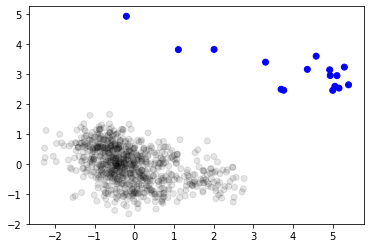

In [7]:
table_encoding = info_dict['vertical_table_encoding']
context = torch.mean(context_encoding.detach(), axis=0).numpy().reshape(-1, 768)

if len(table_encoding.shape) == 3:
    table_rows = torch.mean(table_encoding, axis=1).detach().numpy().reshape(-1, 768)
else:
    table_rows = table_encoding.detach().numpy().reshape(-1, 768)

total = np.concatenate((table_rows, context))

color1 = np.array([0, 0, 0, .1])
color2 = np.array([1, 0, 0, 1])
color3 = np.array([0, 0, 1, 1])

final_colors = [color1 if row != query_matching_index else color2 for row in range(table_rows.shape[0])] + [color3 for context in range(context.shape[0])]

embed = table_encoding[0].detach().numpy()

pca = PCA(n_components=2)
reduced = pca.fit_transform(total)
t = reduced.transpose()
plt.scatter(t[0], t[1], c = final_colors)
plt.show()
plt.close()